In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from numpy import asarray
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T
from torchvision.transforms import Resize, ToTensor, Normalize
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.models as models
from torchsummary import summary

from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

writer = SummaryWriter()

# GPU 사용양 확인할 수 있는 util
from GPUtil import showUtilization as gpu_usage
gpu_usage()

| ID | GPU  | MEM |
-------------------
|  0 | 100% | 40% |


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name(device))

Tesla V100-PCIE-32GB


In [47]:
labels = pd.read_csv('/opt/ml/correct_label.csv')
labels.head()
labels['file'][0].split('/')[-2]

'000001_female_Asian_45'

In [71]:
labels['folder'] = [file.split('/')[-2] for file in labels['file']]
labels.head()

,Unnamed: 0,file,gender,mask,age,id,class,folder
0,0,/opt/ml/input/data/train/images/000001_female_...,1,0,1,000001,4,000001_female_Asian_45
1,1,/opt/ml/input/data/train/images/000001_female_...,1,1,1,000001,10,000001_female_Asian_45
2,2,/opt/ml/input/data/train/images/000001_female_...,1,0,1,000001,4,000001_female_Asian_45
3,3,/opt/ml/input/data/train/images/000001_female_...,1,0,1,000001,4,000001_female_Asian_45
4,4,/opt/ml/input/data/train/images/000001_female_...,1,2,1,000001,16,000001_female_Asian_45


In [2]:
people = pd.read_csv('/opt/ml/input/data/train/train.csv')
people.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [3]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(people, test_size=0.1, random_state=101)
len(train), len(valid)

(2430, 270)

In [4]:
train.head()

,id,gender,race,age,path
1113,003052,female,Asian,19,003052_female_Asian_19
2603,006656,male,Asian,19,006656_male_Asian_19
1820,004284,male,Asian,60,004284_male_Asian_60
2275,006088,male,Asian,18,006088_male_Asian_18
2592,006639,male,Asian,19,006639_male_Asian_19


In [5]:
valid.head()

,id,gender,race,age,path
1427,003483,male,Asian,56,003483_male_Asian_56
182,000564,female,Asian,57,000564_female_Asian_57
442,001062,female,Asian,25,001062_female_Asian_25
1907,004427,female,Asian,29,004427_female_Asian_29
1791,004247,female,Asian,50,004247_female_Asian_50


In [8]:
X_train, y_train = train['path'], train[['gender', 'age']]
X_valid, y_valid = valid['path'], valid[['gender', 'age']]
X_train.head(), type(X_train)

(1113    003052_female_Asian_19
 2603      006656_male_Asian_19
 1820      004284_male_Asian_60
 2275      006088_male_Asian_18
 2592      006639_male_Asian_19
 Name: path, dtype: object,
 pandas.core.series.Series)

In [9]:
y_train.head(), type(y_train)

(      gender  age
 1113  female   19
 2603    male   19
 1820    male   60
 2275    male   18
 2592    male   19,
 pandas.core.frame.DataFrame)

In [9]:
test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
test.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [10]:
base_path = '/opt/ml/input/data/eval/images/'

test_path = [os.path.join(base_path, img) for img in test.ImageID]
test_path[0]

'/opt/ml/input/data/eval/images/cbc5c6e168e63498590db46022617123f1fe1268.jpg'

In [11]:
class TrainDataset(Dataset):
    def __init__(self, file_path, labels, transform, train=True):
        self.train = train
        self.transform = transform
        self.y = labels

        self.X = []
        for x in tqdm(file_path):
            image = Image.open(x)
            image = asarray(image)
            self.X.append(image)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        aug = self.transform(image=X)
        X = aug['image']
        return X, torch.tensor(y)
        

class TestDataset(Dataset):
    
    def __init__(self, file_path, transform):
        self.transform = transform
        self.X = []
        for x in tqdm(file_path):
            image = Image.open(x)
            image = asarray(image)
            self.X.append(image)
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        aug = self.transform(image=X)
        X = aug['image']
        return X

In [12]:
CROP_SIZE = 384
RESIZE = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

cutout = A.Compose([
    A.OpticalDistortion(p=0.5),
    A.OneOf([
        A.Cutout(p=1, num_holes=10, max_h_size=10, max_w_size=6),
        A.GridDistortion(p=1, num_steps=5, interpolation=1, border_mode=1, value=(0, 0, 0)),
    ], p=0.5),
    A.CenterCrop(height=CROP_SIZE+80, width=CROP_SIZE),
    A.Resize(height=RESIZE, width=RESIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

transform = A.Compose([
    A.CenterCrop(height=CROP_SIZE+80, width=CROP_SIZE),
    A.Resize(height=RESIZE, width=RESIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

/opt/conda/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:688: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [13]:
type(x_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [14]:
x_train[100]

'/opt/ml/input/data/train/images/000007_female_Asian_58/mask5.jpg'

In [15]:
age_train_dataset = TrainDataset(
    file_path = x_train,
    labels = y_train,
    transform = cutout
)

100%|██████████| 17010/17010 [01:01<00:00, 278.41it/s]


In [16]:
age_valid_dataset = TrainDataset(
    file_path = x_valid,
    labels = y_valid,
    transform = transform
)

100%|██████████| 1890/1890 [00:06<00:00, 273.53it/s]


In [17]:
test_dataset = TestDataset(
    file_path = test_path,
    transform = transform
)

100%|██████████| 12600/12600 [00:43<00:00, 287.00it/s]


In [18]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 21% |


In [19]:
BATCH_SIZE = 128
age_train_loader = DataLoader(age_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
age_valid_loader = DataLoader(age_valid_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [20]:
next(iter(age_valid_loader))[0].size()

torch.Size([128, 3, 224, 224])

In [21]:
# AgeModel = models.resnet34(pretrained=True).to(device)
# AgeModel.fc = nn.Linear(512, 3, bias=True).to(device)
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.base = models.resnet34(pretrained=True)
        self.base.fc = nn.Linear(512, 128, bias=True)
        self.final = nn.Linear(128, 3, bias=True)
        
    def forward(self, x):
        x = self.base(x)
        x = self.final(x)
        return x

In [22]:
AgeModel = Model().to(device)

# from torchsummary import summary

# summary(AgeModel, (3, 224, 224))

In [27]:
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

LEARNING_RATE = 1e-5
criterion = nn.CrossEntropyLoss()
optA = Adam(AgeModel.parameters(), lr=LEARNING_RATE)
schA = StepLR(optA, step_size=5, gamma=0.5)

In [24]:
def train(model, optimizer, train_loader, val_loader, device, scheduler, epochs=20):
    '''
    writer : tensorboard writer
    '''
    loss_log = []
    criterion = torch.nn.CrossEntropyLoss()

    for e in range(1, epochs+1):
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch in tqdm(iter(train_loader)):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()        
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.squeeze())
            acc = class_acc(y_pred, y_batch.squeeze())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
        scheduler.step()
        # validation set eval
        with torch.no_grad(): 
            val_loss = 0
            val_acc = 0
            for x_val, y_val in iter(val_loader):  
                x_val = x_val.to(device)  
                y_val = y_val.to(device)
#                 model.eval()  

                yhat = model(x_val)  
                val_loss += criterion(yhat, y_val.squeeze()).item()
                val_acc += class_acc(yhat, y_val.squeeze()).item()


        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.4f} | Acc: {epoch_acc/len(train_loader):.3f} \
        | Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc/len(val_loader):.3f}')
        new_loss = val_loss/len(val_loader)
        loss_log.append(new_loss)
        if len(loss_log) <= 8:
            continue
        if np.mean(loss_log[-5:])/new_loss < 1.2:
            print('Early Stopping!')
            break

In [25]:
def class_acc(y_pred, y_test):    
    output = torch.argmax(y_pred, dim=1)
    correct = sum(output == y_test)/len(output)
    return correct

In [28]:
train(
    model = AgeModel,
    optimizer = optA,
    train_loader = age_train_loader,
    val_loader = age_valid_loader,
    device = device,
    scheduler = schA,
    epochs = 5
)

  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 001: | Loss: 0.0012 | Acc: 0.999         | Val Loss: 0.0053 | Val Acc: 0.999


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 002: | Loss: 0.0005 | Acc: 1.000         | Val Loss: 0.0066 | Val Acc: 0.999


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 003: | Loss: 0.0012 | Acc: 1.000         | Val Loss: 0.0048 | Val Acc: 0.998


  0%|          | 0/132 [00:00<?, ?it/s]

Epoch 004: | Loss: 0.0006 | Acc: 1.000         | Val Loss: 0.0063 | Val Acc: 0.999


100%|██████████| 132/132 [02:00<00:00,  1.09it/s]


Epoch 005: | Loss: 0.0015 | Acc: 1.000         | Val Loss: 0.0070 | Val Acc: 0.998


In [29]:
def predictTestData(model, loader, transform, device):
#         model.eval()
        predict = []
        for images in tqdm(loader):
            with torch.no_grad():
                images = images.to(device)
                pred = model(images)
                pred = pred.argmax(dim=-1)
                predict.extend(pred.cpu().numpy())
#         self.data['ans'] = all_predictions
        return np.array(predict)

In [30]:
submission = pd.read_csv('/opt/ml/input/data/eval/info.csv')
submission.head()

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0


In [31]:
submission['age'] = predictTestData(AgeModel, test_loader, transform, device)

100%|██████████| 99/99 [00:36<00:00,  2.69it/s]


In [32]:
submission.tail()

,ImageID,ans,age
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,0,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,0,1
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0,0
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,0,1
12599,f1e0b9594ae9f72571f0a9dc67406ad41f2edab0.jpg,0,1


In [33]:
submission['age'].value_counts().sort_index()

0    5365
1    6397
2     838
Name: age, dtype: int64

In [34]:
test_transform = T.Compose([
#     T.RandomPerspective(distortion_scale=0.05, p=1.0),
    T.CenterCrop((CROP_SIZE+80, CROP_SIZE)),
    T.Resize((RESIZE, RESIZE)),
#     T.ToTensor(),
#     T.Normalize(mean=mean, std=std)
])

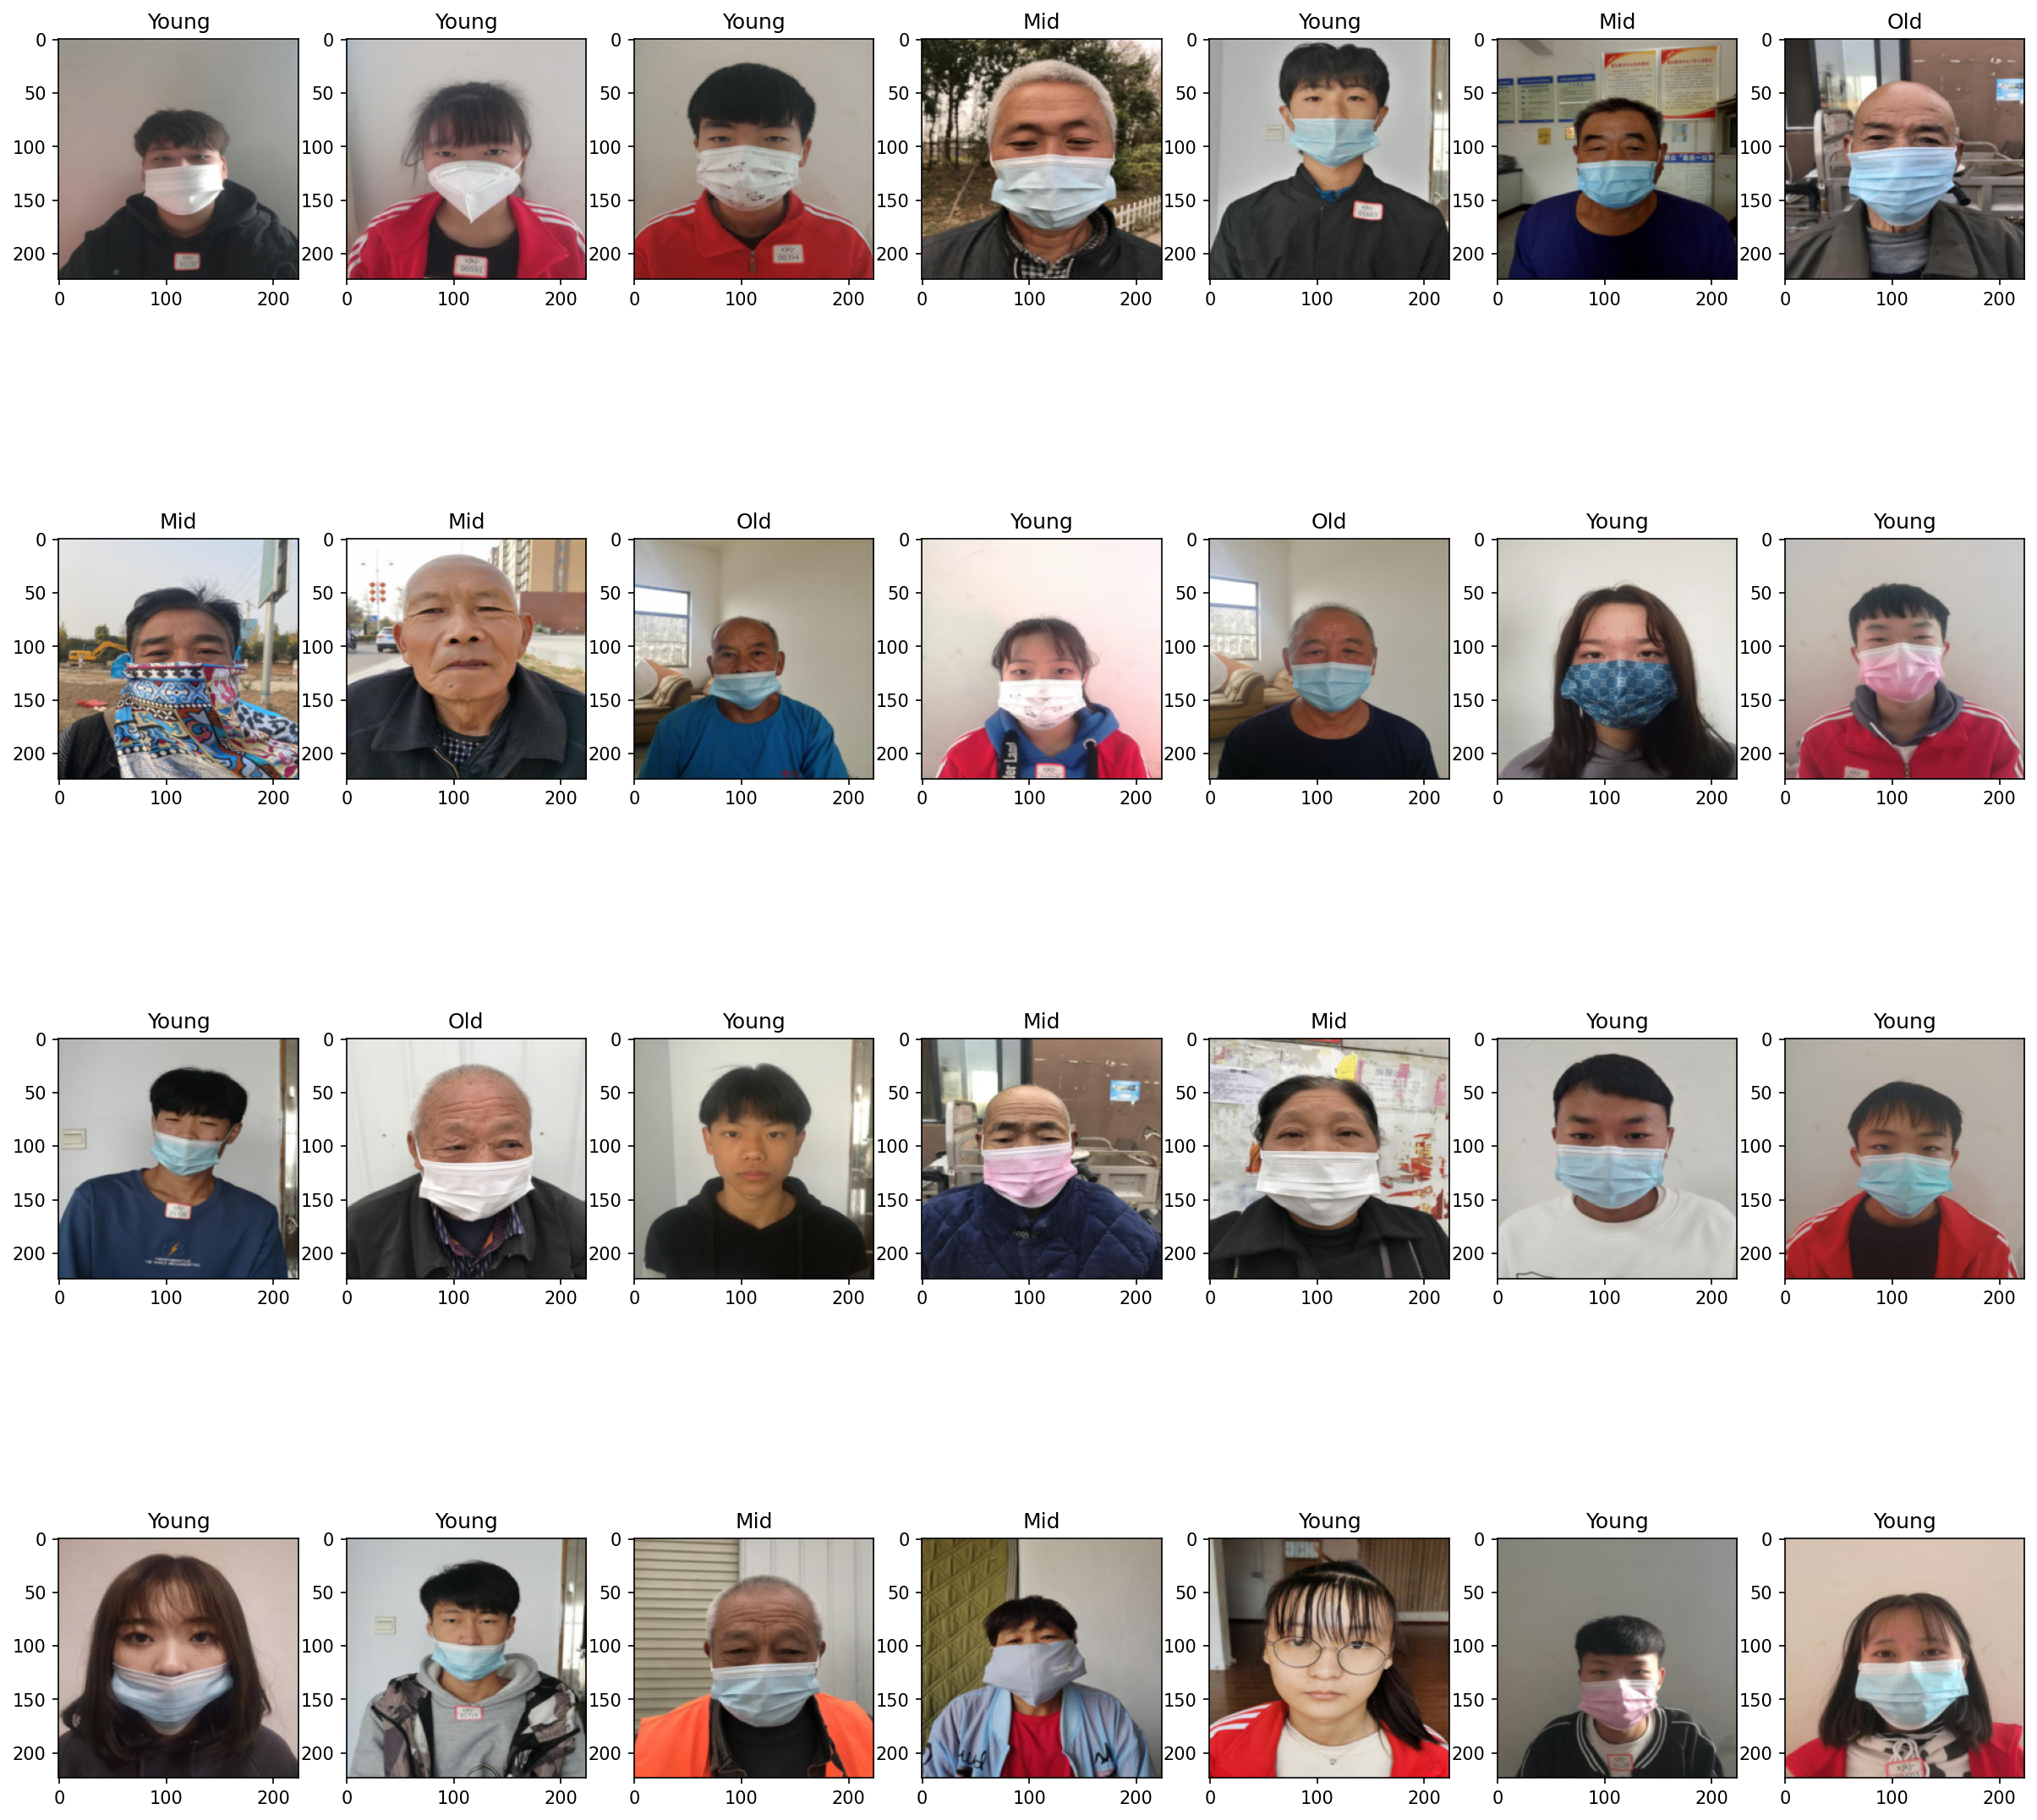

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
test_dir = '/opt/ml/input/data/eval/images/'

%matplotlib inline

age = {0:'Young', 1:'Mid', 2:'Old'}

fig, axes = plt.subplots(4, 7, figsize=(20,20), dpi=150)
for i in range(4):
    for j in range(7):
        n = randint(0, 12599)
        im = Image.open(os.path.join(test_dir, submission.ImageID[n]))
        im = test_transform(im)
        axes[i][j].imshow(im)
        axes[i][j].set_title(age[submission['age'][n]])
plt.show()

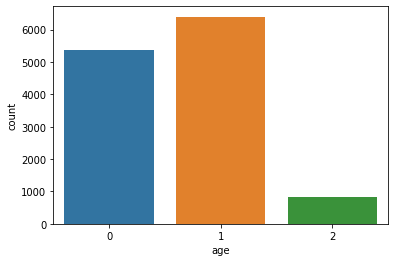

In [36]:
import seaborn as sns

sns.countplot(x='age', data=submission)

In [37]:
init_dir = '/opt/ml/'
submission.to_csv(os.path.join(init_dir, 'age_2.csv'))